In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from network import Network
import matplotlib.pyplot as plt

First, read in problem parameters. These can come from any source, but they should be reshaped into `np.array` objects with dimensions specified in the docstring of `sim`.

In [2]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

transition = .9

# Key/value pairs are the names and contents of the sheets in the excel model data
model_df = pd.read_excel('Example11_9_Network_Model_Jul19.xlsx', sheet_name=None)

# The initial conditions of the demand curves
load = model_df['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
demand = load.loc[:,load.columns.str.contains('Load')]/base
demand.columns = demand.columns.str.replace('Load','').astype(int)
price = load.loc[:,load.columns.str.contains('Price')]
price.columns = price.columns.str.replace('Price','').astype(int)

# Generation profiles for intermittant sources
int_gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
int_gen.index+=pd.TimedeltaIndex(int_gen.HE-1, unit='h')
int_gen = int_gen.drop(columns='HE')
int_gen = int_gen.loc[load.index, model_df['Gen']['Type']]
int_gen = int_gen*np.array(model_df['Gen']['Installed MW'])/base
int_gen.columns = np.array(model_df['Gen']['Number of Bus'])

# Set elasticity constant, for now
epsilon = demand.copy()
epsilon[:] = -.5

voll = price.copy()
voll[:] = price*2

profile = pd.concat(
    {
        'nom_load': demand,
        'nom_price': price,
        'elasticity': epsilon,
        'voll': voll,
        'int_gen': transition*int_gen
    },
    axis='columns'
)

In [3]:
# Process Ybus matrix
Y = model_df['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model_df['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# Number of timesteps to fully charge/discharge storage
b_duration = 4

# Dispatchable generator costs
cost_coeffs = np.array(
    [
        [10,8,12],
        [.016,0.18,0.18]
    ]
)

Instantiate model

In [4]:
model = Network(
    B=B,
    line_lims=P_line,
    profile=profile,
    dis_max=(1-transition)*np.array(model_df['Gen']['Installed MW'])/base,
    total_storage=2000/base,
    storage_cycle_timesteps=4,
    cost_coeffs=cost_coeffs
)

Solve model

In [5]:
model.solve()

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 20 05:19:34 PM: Your problem has 418 variables, 34 constraints, and 0 parameters.
(CVXPY) Dec 20 05:19:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 20 05:19:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 20 05:19:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 20 05:19:34 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 20 05:19:34 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

<Axes: >

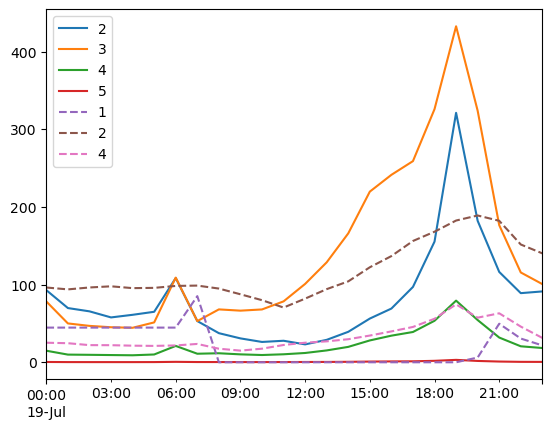

In [6]:
ax = model.profile.consumer_surplus.plot()
model.profile.producer_surplus.plot(ax=ax,style='--')
# ax.legend(('consumer surplus','producer surplus'))